# Reanalysis preprocessing
***

__Author__: Chus Casado<br>
__Date__:   24-02-2022<br>

__Introduction__:<br>
This code extracts from the EFAS reanalysis data the discharge series in a selection of fixed reporting points.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

path_root = os.getcwd()

## 1 Configuration

In [70]:
# area threshold
area_threshold = 500

# return period
rp = 5

# start and end of the study period
start = '2020-10-14 12:00:00'
end = None

## 2 Stations

Load the table with all EFAS fixed reporting point and filter those points for which discharge data will be extracted.

In [86]:
# load table of fixed reporing points
stations = pd.read_csv('../data/Station-2022-10-27v12.csv', index_col='station_id')

# filter stations and fields
mask = (stations['DrainingArea.km2.LDD'] >= area_threshold) & (stations.FixedRepPoint == True)
stations = stations.loc[mask, ['StationName', 'LisfloodX', 'LisfloodY', 'Catchment', 'River', 'EC_Catchments', 'Country code']]

print(f'No. stations:\t{stations.shape[0]}')

# xarrys with station coordinates that will be used to extract data
x = xr.DataArray(stations_sel.LisfloodX, dims='id')
y = xr.DataArray(stations_sel.LisfloodY, dims='id')

No. stations:	2371


## 3 Discharge data

It loads the EFAS discharge reanalyses for the complete EFAS domain, and out of if only it extracts the discharge time series for the previously selected reporting points and the study period. The discharge timeseries are saved in a _parquet_ file.

In [85]:
var = 'discharge'

# output folder
out_path = f'../data/{var}/reanalysis/'
if os.path.exists(out_path) is False:
    os.makedirs(out_path)

# local directory where I have saved the raw data
path_reanalysis = 'E:/casadje/Documents/skill_assessment/data/CDS/reanalysis/'

# load dataset and extract variable discharge
files = glob.glob(f'{path_reanalysis}*202[0-3].nc')
dis = xr.open_mfdataset(files)['dis06']

# trim data to the study period
dis = dis.sel(time=slice(start, None))



# extract discharge for the selected stations
dis = dis.sel(x=x, y=y, method='nearest')
dis = dis.drop(['x', 'y', 'step', 'surface', 'latitude', 'longitude', 'valid_time'])

# compute the lazy DataArray
dis = dis.compute()

# # save extraction as NetCDF
# dis.to_netcdf(f'{out_path}EFAS_discharge_reanalysis.nc')
# save extraction as Parquet
dis_df = pd.DataFrame(dis.data, index=dis.time.data, columns=dis.id.data.astype(str))
exc_df.to_parquet(f'{out_path}EFAS_discharge_reanalysis.parquet')

**Check discharge timeseries**

To visually check the time series, we will plot the data for the Ebro catchment.

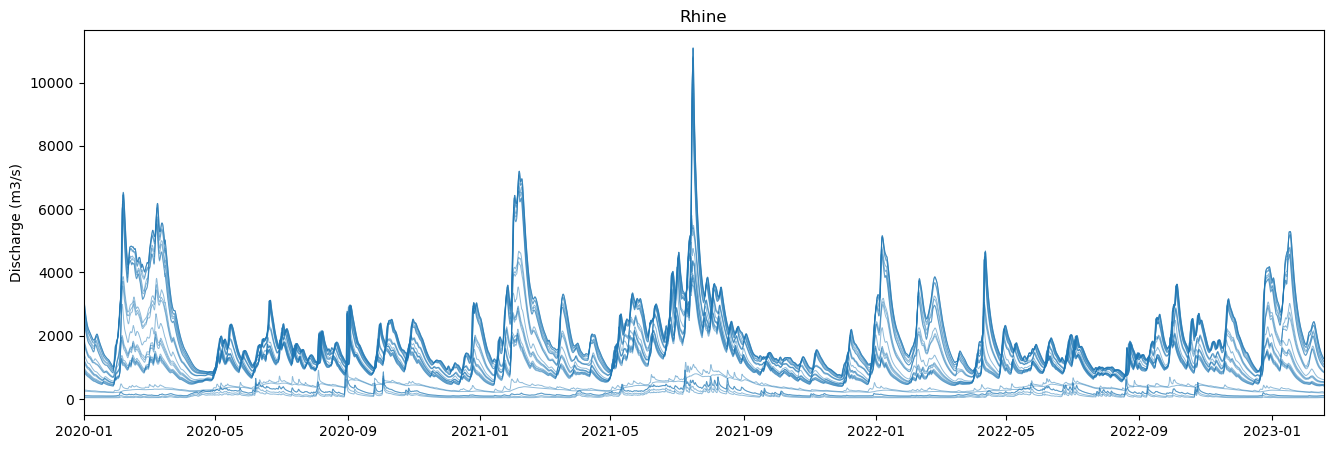

In [90]:
catchment = 'Rhine'

# filter stations in the catchment
stn_catchment = stations_sel.loc[stations_sel.River == catchment, :]

# plot discharge
plt.figure(figsize=(16, 5))
for stn in stn_catchment.index:
    plt.plot(dis_sel.time, dis_sel.sel(id=stn).data, lw=.7, c='C0', alpha=.5)
plt.title(catchment)
plt.xlim(dis_sel.time[[0, -1]].data)
plt.ylabel('Discharge (m3/s)');

## 4 Exceedance

### 4.1 Discharge thresholds

The discharge thresholds are the discharge values for return periods 1.5, 2, 5, 10, 20, 50, 100, 200 and 500 years. The data is supplied in a NetCDF file that contains all the river network in Europe. This NetCDF is loaded as an _xarray_ and the values corresponding to the selected reporting points are extracted.

In [91]:
# load thresholds
path_thresholds = f'../data/thresholds/'
thresholds = xr.open_dataset(f'{path_thresholds}return_levels.nc')

# extract thresholds for the selected stations
thresholds = thresholds.sel(x=x, y=y, method='nearest')
thresholds = thresholds.drop(['x', 'y'])

### 4.2 Exceedance over threshold

This block of code computes the exceedances of the 5-year return period out of the discharge timeseries and thresholds that were previously extracted. The results are seved in a _parquet_ file that will be used in the succeeding analys.

In [92]:
var = 'exceedance'

# output folder
out_path = f'../data/{var}/reanalysis/'
if os.path.exists(out_path) is False:
    os.makedirs(out_path)

# compute exceedance
thr = f'rl{rp}'
exc = dis_sel >= thresholds[thr]

# # save as NetCDF
# exc.to_netcdf(f'{out_path}exceedance_rl{rp}.nc')
# save as Parquet
exc_df = pd.DataFrame(exc.data, index=exc.time.data, columns=exc.id.data.astype(str))
exc_df.to_parquet(f'{out_path}exceedance_rl{rp}.parquet')